In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import csv as csv
import re
import random

from scipy.signal import find_peaks
from sklearn.svm import SVR
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from xgboost import plot_importance
from sklearn import preprocessing, metrics, ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,KFold,train_test_split
from sklearn.preprocessing import Imputer,scale,StandardScaler
from sklearn.linear_model import LinearRegression
from collections import OrderedDict

sns.set(style="ticks")
plt.style.use('ggplot')

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()


In [2]:
# load data
df_train=pd.read_csv("data/MLB_train.csv",index_col="id")
df_test=pd.read_csv("data/MLB_test.csv")

In [3]:
df_train.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary_next_year
id,,,,,,,,,,,,,,,,,,,,,
0,nelsoge01,1986,1,CHA,AL,6,6,54,1,0,...,3.0,3.0,0.0,488.0,26.0,52,NaN,NaN,NaN,365000.0
1,moyerja01,1997,1,SEA,AL,17,5,30,30,2,...,3.0,7.0,0.0,787.0,0.0,82,NaN,NaN,NaN,2000000.0
2,thompbr01,2008,1,SLN,NL,6,3,26,6,0,...,2.0,3.0,0.0,273.0,10.0,38,NaN,NaN,NaN,650000.0
3,powerte01,1986,1,CIN,NL,10,6,56,10,0,...,5.0,1.0,1.0,537.0,30.0,59,NaN,NaN,NaN,500000.0
4,osunaan01,2003,1,NYA,AL,2,5,48,0,0,...,3.0,2.0,0.0,232.0,16.0,22,NaN,NaN,NaN,750000.0


In [4]:
df_test.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,6284,cormirh01,2000,1,BOS,AL,3,3,64,0,...,2.0,1.0,0.0,0.0,293.0,12.0,40,NaN,NaN,NaN
1,6285,reyesde01,2003,1,PIT,NL,0,0,12,0,...,1.0,5.0,0.0,0.0,50.0,4.0,13,NaN,NaN,NaN
2,6286,runyase01,1999,1,DET,AL,0,1,12,0,...,1.0,2.0,1.0,0.0,45.0,2.0,4,NaN,NaN,NaN
3,6287,byrdpa01,2002,1,KCA,AL,17,11,33,33,...,1.0,3.0,7.0,1.0,935.0,0.0,111,NaN,NaN,NaN
4,6288,parkch01,2006,1,SDN,NL,7,7,24,21,...,7.0,5.0,10.0,0.0,606.0,0.0,81,NaN,NaN,NaN


In [5]:
# 讓 train/test id 大幅度拆開，之後好處理
df_test['id']=df_test['id']+1000000 
df_test.set_index("id" , inplace=True)

In [6]:
# 強烈建議不要下sort，預設是False，原因口頭說明
df_all=pd.concat([df_train,df_test],sort=False) 

In [7]:
# 觀察null分布
df_all.isnull().sum().to_frame(name='nullCount')[df_all.isnull().sum()>0]

,nullCount
BAOpp,2887
IBB,1
WP,1
HBP,1
BK,1
SH,7393
SF,7393
GIDP,7393
salary_next_year,1109


In [8]:
# 看起來 'SH','SF','GIDP' 完全沒資料，'BAOpp' 缺一堆，直接drop 
df_all.drop(columns=['SH','SF','GIDP','BAOpp'],inplace=True)

In [9]:
# 觀察一下三個 df 的形狀，df_all應該是 df_train+df_test 的數量
# X數量不一致因為我們前一步drop df_all 的少部分X
df_train.shape,df_test.shape,df_all.shape

((6284, 31), (1109, 30), (7393, 27))

In [10]:
# 觀察一下欄位的型態
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7393 entries, 0 to 1007392
Data columns (total 27 columns):
playerID            7393 non-null object
yearID              7393 non-null int64
stint               7393 non-null int64
teamID              7393 non-null object
lgID                7393 non-null object
W                   7393 non-null int64
L                   7393 non-null int64
G                   7393 non-null int64
GS                  7393 non-null int64
CG                  7393 non-null int64
SHO                 7393 non-null int64
SV                  7393 non-null int64
IPouts              7393 non-null int64
H                   7393 non-null int64
ER                  7393 non-null int64
HR                  7393 non-null int64
BB                  7393 non-null int64
SO                  7393 non-null int64
ERA                 7393 non-null float64
IBB                 7392 non-null float64
WP                  7392 non-null float64
HBP                 7392 non-null float64

In [11]:
# 為了方便展開前後年的資料，我們需要group by playerID/yearID 再 remap
# 但是我不會 map 兩個欄位 (沒有仔細去了解 map 用法)，我用偷吃步先把 playerID/yearID 串起來當成新的欄位
# 要注意 yearID 原型是 int 需要 astype(str)，str+str = 串在一起的 string ex: aaa+bbb=aaabbb
df_all['PYID'] = df_all['playerID'] + df_all['yearID'].astype('str')

In [12]:
for x in ['playerID','yearID','PYID']:
    print(df_all[x].is_unique)

False
False
True


In [13]:
# 看一下處理後的 df_all，PYID此欄位就是我們剛剛產生的串燒
df_all.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year,PYID
id,,,,,,,,,,,,,,,,,,,,,
0,nelsoge01,1986,1,CHA,AL,6,6,54,1,0,...,3.85,5.0,3.0,3.0,0.0,488.0,26.0,52,365000.0,nelsoge011986
1,moyerja01,1997,1,SEA,AL,17,5,30,30,2,...,3.86,2.0,3.0,7.0,0.0,787.0,0.0,82,2000000.0,moyerja011997
2,thompbr01,2008,1,SLN,NL,6,3,26,6,0,...,5.15,1.0,2.0,3.0,0.0,273.0,10.0,38,650000.0,thompbr012008
3,powerte01,1986,1,CIN,NL,10,6,56,10,0,...,3.70,10.0,5.0,1.0,1.0,537.0,30.0,59,500000.0,powerte011986
4,osunaan01,2003,1,NYA,AL,2,5,48,0,0,...,3.73,3.0,3.0,2.0,0.0,232.0,16.0,22,750000.0,osunaan012003


In [14]:
# 因為是時間序列的關係，我們可以把每一筆資料都插入前n年/後m年的資料，以下是處理手段

In [15]:
# 此部分是補插方法，我用的是移動參照的方式，因為補插的欄位很多，我懶惰不想反覆寫，所以建立一個function來處理，
def insert_X(target_Xs,theRange):
    for col in target_Xs:
        for i in list(range(-1*theRange,theRange)):
            t = df_all.groupby(['playerID','yearID'])[col].mean().to_frame(name=col).reset_index()
            t['yearID'] = t['yearID'] +i
            t['PYID'] =  t['playerID'].astype('str') + t['yearID'].astype('str')
            t=t.set_index('PYID').copy()
            t.drop(columns=['playerID','yearID'],inplace=True)
            t = t.to_dict()
            t=t[col]

            if i<0:
                str_i = 'm' + str(abs(i))
            else:
                str_i = str(i)
            df_all[col+'_t'+str_i] = df_all.PYID.map(t)
    return df_all

In [16]:
# 針對 salary 我驗證 前後 19 年 的資料效果最好
df_all = insert_X(['salary_next_year'],19).copy()

In [17]:
df_all.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,salary_next_year_t9,salary_next_year_t10,salary_next_year_t11,salary_next_year_t12,salary_next_year_t13,salary_next_year_t14,salary_next_year_t15,salary_next_year_t16,salary_next_year_t17,salary_next_year_t18
id,,,,,,,,,,,,,,,,,,,,,
0,nelsoge01,1986,1,CHA,AL,6,6,54,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,moyerja01,1997,1,SEA,AL,17,5,30,30,2,...,205000.0,142500.0,70000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,thompbr01,2008,1,SLN,NL,6,3,26,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,powerte01,1986,1,CIN,NL,10,6,56,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,osunaan01,2003,1,NYA,AL,2,5,48,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# 'SO','W','HR','HBP','GF','BFP','HR' 這些欄位我就不一一驗證
# 全部補到最大的年份差 26 (我針對整份資料的最大最小年去相減得到 26)
df_all = insert_X(['SO','W','HR','HBP','GF','BFP','HR'],26).copy()

In [13]:
# 看一下 df_all 的欄位，應該很炸 (可以看一下最後的 columns 數，woooo~)
df_all.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,BFP_t16,BFP_t17,BFP_t18,BFP_t19,BFP_t20,BFP_t21,BFP_t22,BFP_t23,BFP_t24,BFP_t25
id,,,,,,,,,,,,,,,,,,,,,
0,nelsoge01,1986,1,CHA,AL,6,6,54,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,moyerja01,1997,1,SEA,AL,17,5,30,30,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,thompbr01,2008,1,SLN,NL,6,3,26,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,powerte01,1986,1,CIN,NL,10,6,56,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,osunaan01,2003,1,NYA,AL,2,5,48,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# 超級關鍵，因為我們剛剛回插的時候把薪水當年的值也寫入X，這樣肯定 overfit，故要把這個值拿掉
# 同時 PYID 也不需要再被使用，所以捨棄他
df_all.drop(columns=['PYID','salary_next_year_t0'],inplace=True)

In [15]:
# 為了避免剛剛的動作再我接下來的預測被我亂動到，我複製一份出來
df_all_done = df_all.copy()

In [16]:
# # 脫褲子放屁
# df_all_done['playerID'] = le.fit_transform(df_all_done['playerID'].astype("str"))
# df_all_done['lgID'] = le.fit_transform(df_all_done['lgID'].astype("str"))

In [17]:
# 這裡就是放屁，何必上面的脫褲子，簡單的說 one_hat 就隱含了labeling的意義，根本不要先labeling
df_all_done = pd.get_dummies(df_all_done,columns = ['playerID','lgID'])

In [18]:
# 把不要的欄位丟掉，我發現 teamID 跟 stint 沒有用，這是反覆驗證的結果，過程就是抽看看，看分數而已
df_all_done.drop(columns=['teamID','stint'],inplace=True)

In [19]:
# 一開始我們把測試集 ID+1000000 再 concat 的好處在這裡
# 用這個手法可以很輕鬆地把 df_all_done 再切開
df_train_done = df_all_done[df_all_done.index < 1000000]
df_test_done = df_all_done[df_all_done.index >= 1000000]

In [20]:
# 同樣驗證一下形狀
df_train_done.shape,df_test_done.shape,df_all_done.shape

((6284, 1625), (1109, 1625), (7393, 1625))

In [21]:
# 超參 - 驗證 test_size 分配的最佳解

# df_score = pd.DataFrame(columns=['i','score', 'mae'])
# k=0
# for i in [i*0.01 for i in range(1,100)]:
#     X= df_train_done.drop(columns=['salary_next_year']).copy()
#     y= df_train_done['salary_next_year'].copy()

#     X_train, X_test, y_train, y_test = (train_test_split(X, 
#                                                          y,
#                                                          test_size=i,shuffle=True,random_state=9999))
#     clf = clf.fit(X_train, y_train) 

#     predict_train = clf.predict(X_test)
#     #accuracy_train = accuracy_score(y_test,predict_train)

#     y_pred = clf.predict(X_test)
#     df_score.loc[k] = (str(i),clf.score(X_test,y_test),metrics.mean_absolute_error(y_test, y_pred))
#     k=k+1
#     print(k,end=',')
#     if (k%10==0):
#         print(' ')
# df_score.loc[df_score['score'].idxmax()].to_frame(name='test')

In [22]:
# #超參各參數
# X= df_train_done.drop(columns=['salary_next_year']).copy()
# y= df_train_done['salary_next_year'].copy()

# X_train, X_test, y_train, y_test = (train_test_split(X, 
#                                                      y,
#                                                      test_size=0.02,shuffle=False,random_state=9999))
# for z in [X,y,X_train, X_test, y_train, y_test]:
#     print(z.shape)
parameters_for_testing = {
      'learning_rate': [round(i,4) for i in np.arange(0.0845,0.0855,0.0001)],
         'n_estimators': [i for i in np.arange(185,195,1)],
    'n_estimators': [109,190],
# #      'max_depth': range(9,11,1),
#       'min_child_weight': range(1,10)
# #     'max_delta_step': [0,1,2]   
# #      'gamma':[i/10.0 for i in range(0,5)]
# #     'subsample': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1],
# #    'reg_alpha': [i for i in np.arange(0.001,0.01,0.001)],
# #     'reg_lambda': [i for i in np.arange(0.5,1,0.1)]
# }

# xgb_model = xgb.XGBRegressor(
#     base_score=0.5,
#     booster='gbtree',
#     colsample_bylevel=1,
#     colsample_bytree=1,
#     gamma=0,
#       learning_rate=0.085,
#          n_estimators=191,
#     max_delta_step=0,
#      max_depth=9,
#      min_child_weight=1,

#     missing=None,

#     verbose=1,
#     n_jobs=-1,nthread=-1,objective='reg:linear',random_state=0,reg_alpha=0,reg_lambda=1,
#     scale_pos_weight=1,seed=None,silent=True,subsample=1,tree_method = 'gpu_hist',predictor='gpu_predictor'
# )

# gsearch1 = GridSearchCV(cv=2,estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=1, verbose=2,scoring='neg_mean_absolute_error')
# gsearch1.fit(X_train,y_train)
# #print (gsearch1.grid_scores_)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

In [23]:
# 完成最佳超參之後
# 把 train 利用 train_test_split 切開
X= df_train_done.drop(columns=['salary_next_year']).copy()
y= df_train_done['salary_next_year'].copy()

X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y,
                                                     test_size=0.0195,shuffle=True,random_state=9999))

In [18]:
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
clf = xgb.XGBRegressor(
    #以下代入最佳超參
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.03999991,
    max_delta_step=0,
    max_depth=8,
    min_child_weight=3,
    missing=None,
    n_estimators=103,
    verbose=1,
    n_jobs=-1,nthread=-1,objective='reg:linear',random_state=0,reg_alpha=0,reg_lambda=1,
    scale_pos_weight=1,seed=None,silent=True,subsample=1,tree_method = 'gpu_hist',predictor='gpu_predictor'
)

clf = clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

#使用 cross_val_score + kfold 驗證分數，分數依據 neg_mean_absolute_error (MAE)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error',verbose=1) 
print(np.mean(-1*results))
print("score: ", clf.score(X_test,y_test))
print("mae:  ", metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


627305.1524555627
score:  0.9410601134932525
mae:   422976.9925050813


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   53.7s finished


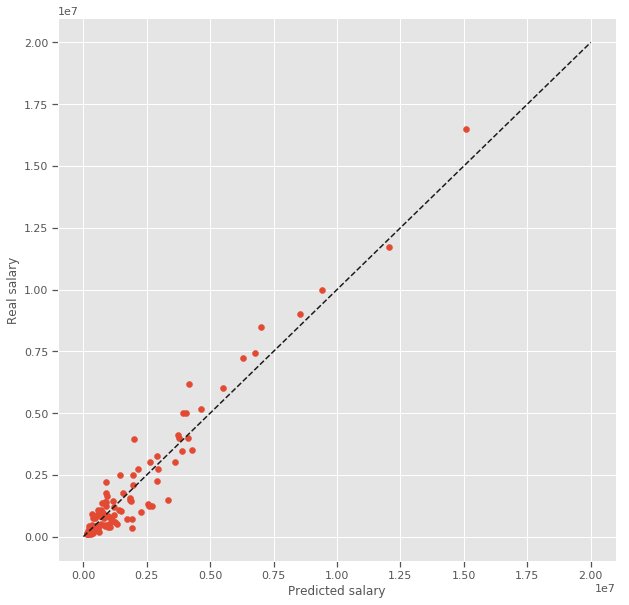

In [25]:
#畫個圖
plt.figure(figsize=(10,10))
plt.scatter((clf.predict(X_test)),(y_test))   ##expm1
plt.plot([0, 20000000], [0, 20000000],'--k')
plt.axis('tight')
plt.xlabel('Predicted salary')
plt.ylabel('Real salary') 
plt.show()

In [26]:
# 實際去預測 test 集
df_test = df_all_done[df_all_done.index > 1000000].drop(columns=['salary_next_year']).copy()
yy_pred = clf.predict(df_test)
df_test['salary_next_year']=yy_pred
df_test['id'] = df_test.index-1000000
df_test.head()
df_test['dup_id'] = df_test['id']
df_test.set_index('dup_id',inplace=True)

In [27]:
# 在這裡我把剛剛預測出的答案再回灌回最乾淨的 train，再做一次剛剛所做的步驟(除了超參)
# 好處是剛剛展開的年份的 na 會再補得更完整一點

In [28]:
df_test2=pd.read_csv("data/MLB_test.csv")
df_test2 = df_test2.merge(df_test[['id','salary_next_year']]
                                                 ,on='id'
                                                 ,how='left')

In [29]:
df_test2['id']=df_test2['id']+1000000
df_test2.set_index("id" , inplace=True)
df_all=pd.concat([df_train,df_test2],sort=False)
df_all.drop(columns=['SH','SF','GIDP','BAOpp'],inplace=True)
cat_f = ['playerID','teamID','lgID','stint']
cat_f_no_salary = ['playerID','yearID','teamID','lgID','stint','salary_next_year','BAOpp']

In [30]:
df_train.shape,df_test.shape

((6284, 31), (1109, 1626))

In [31]:
df_all['PYID'] = df_all['playerID'].astype('str') + df_all['yearID'].astype('str')

In [32]:
df_all = insert_X('salary_next_year',19).copy()

In [33]:
for x in ['SO','W','HR','HBP','GF','BFP','HR']:
    df_all = insert_X(x,26).copy()

In [34]:
df_all.drop(columns=['PYID','salary_next_year_t0'],inplace=True)

In [35]:
df_all_done = df_all.copy()
df_all_done['playerID'] = le.fit_transform(df_all_done['playerID'].astype("str"))
df_all_done['lgID'] = le.fit_transform(df_all_done['lgID'].astype("str"))
df_all_done = pd.get_dummies(df_all_done,columns = ['playerID','lgID'])

In [36]:
df_all_done.drop(columns=['teamID','stint'],inplace=True)

In [37]:
df_train_done = df_all_done[df_all_done.index < 1000000]
df_test_done = df_all_done[df_all_done.index >= 1000000]

In [38]:
df_train_done.shape,df_test_done.shape

((6284, 1625), (1109, 1625))

In [39]:
X= df_train_done.drop(columns=['salary_next_year']).copy()
y= df_train_done['salary_next_year'].copy()

X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y,
                                                     test_size=0.0195,shuffle=True,random_state=9999))

In [40]:
clf = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.03999,
    max_delta_step=0,
    max_depth=8,
    min_child_weight=3,
    missing=None,
    n_estimators=103,
    verbose=1,
    n_jobs=-1,nthread=-1,objective='reg:linear',random_state=0,reg_alpha=0,reg_lambda=1,
    scale_pos_weight=1,seed=None,silent=True,subsample=1,tree_method = 'gpu_hist',predictor='gpu_predictor'
)

clf = clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error',verbose=1) 
print(np.mean(-1*results))
print("score: ", clf.score(X_test,y_test))
print("mae:  ", metrics.mean_absolute_error(y_test, y_pred))
print("=====")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


574560.8532939091
score:  0.9355463534989196
mae:   413993.59603658534
=====


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   53.9s finished


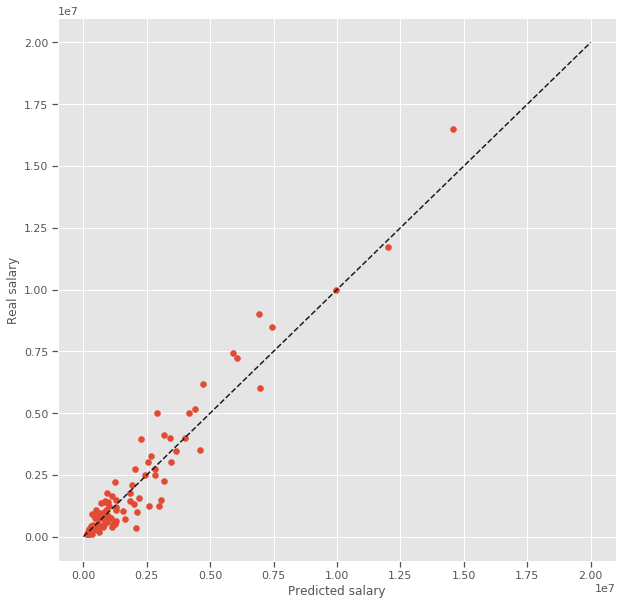

In [41]:
#畫個圖
plt.figure(figsize=(10,10))
plt.scatter((clf.predict(X_test)),(y_test))   ##expm1
plt.plot([0, 20000000], [0, 20000000],'--k')
plt.axis('tight')
plt.xlabel('Predicted salary')
plt.ylabel('Real salary') 
plt.show()

In [42]:
df_test = df_all_done[df_all_done.index > 1000000].drop(columns=['salary_next_year']).copy()
yy_pred = clf.predict(df_test)
df_test['salary_next_year']=yy_pred
df_test['id'] = df_test.index-1000000
df_test.head()
df_test['dup_id'] = df_test['id']
df_test.set_index('dup_id',inplace=True)

In [43]:
# 回插資料，產出
submit = pd.read_csv("data/MLB_submission_example.csv")

In [44]:
submit = submit.drop(columns=['salary_next_year']).merge(df_test[['id','salary_next_year']]
                                                 ,on='id'
                                                 ,how='left')

In [45]:
submit.head()

,id,salary_next_year
0,6284,2.246405e+06
1,6285,7.662686e+05
2,6286,4.206746e+05
3,6287,1.909039e+06
4,6288,1.414221e+07


In [46]:
# submit.to_csv('data/1122_JY2.csv',index=False)

In [47]:
# 在這個議題上，主要我看的是 MAE 望小，試著第三次執行，會發現 MAE 不會變少
# 故只做一次回補 (一次回補的結果 MAE 確實更小了)